In [ ]:
# !pip install --upgrade --no-cache-dir gdown

In [ ]:
# !gdown https://drive.google.com/uc?id=1dXD4MIzHgJ31xVGfDdBx0cgwZs1_W589  

In [ ]:
# !unzip /content/rps.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/FlyAiAugmentationTestFile')

In [ ]:
type(data_dir)

pathlib.PosixPath

In [ ]:
fnames = list(data_dir.glob('*/*.png'))
fnames[0]

PosixPath('/content/FlyAiAugmentationTestFile/scissors/IEE3kJIfbClsf54v.png')

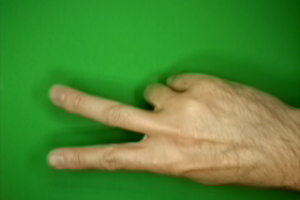

In [ ]:
import PIL
import PIL.Image

PIL.Image.open(fnames[0])

In [ ]:
image_size = (200, 200)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    image_size = image_size,
    batch_size = batch_size,
    seed = 2022
)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    image_size = image_size,
    batch_size = batch_size,
    seed = 2022
)


Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.1,
    subset = 'validation',
    image_size = image_size,
    batch_size = batch_size,
    seed = 2022
)

Found 2188 files belonging to 3 classes.
Using 218 files for validation.


In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
data_augment = keras.Sequential([
    layers.Resizing(200, 200),
    layers.RandomFlip('horizontal'),
    layers.RandomFlip('vertical'),
    layers.RandomRotation(0.1)
])

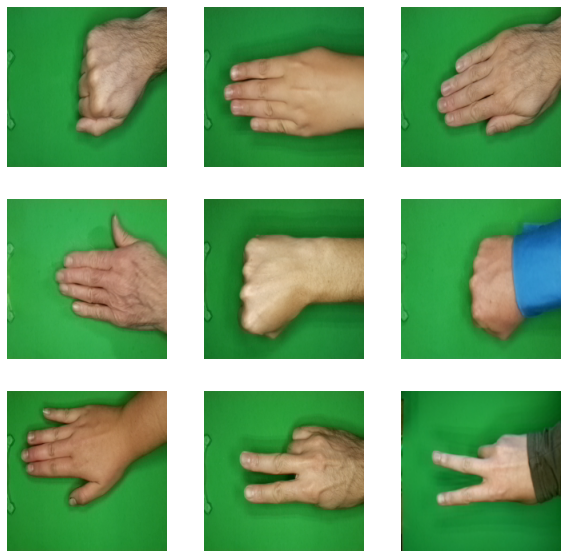

In [ ]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augment(images)
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i].numpy().astype('int'))
    plt.axis('off')
  plt.show()

In [ ]:
train_ds = train_ds.map(
    lambda img, label : (data_augment(img), label),
    num_parallel_calls = tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda img, label : (data_augment(img), label),
    num_parallel_calls = tf.data.AUTOTUNE
)

test_ds = val_ds.map(
    lambda img, label : (data_augment(img), label),
    num_parallel_calls = tf.data.AUTOTUNE
)

In [ ]:
def flyai_model():
  model = keras.Sequential([
      layers.Conv2D(32,3, activation = 'leaky_relu', input_shape = (200, 200, 3)),
      layers.BatchNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(64,3, activation = 'leaky_relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(128,3, activation = 'leaky_relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(256,3, activation = 'leaky_relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(2),
      layers.Conv2D(512,3, activation = 'leaky_relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(2),

      layers.Flatten(),
      layers.BatchNormalization(),

      layers.Dense(256, activation = 'leaky_relu'),
      layers.Dense(128, activation = 'leaky_relu'),
      layers.Dense(60, activation = 'leaky_relu'),
      layers.Dense(16, activation = 'leaky_relu'),
      layers.Dense(3, activation = 'softmax'),
  ])

  model.compile(
      optimizer = 'sgd',
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy']
  )

  return model

In [ ]:
model = flyai_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_28 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_29 (Bat  (None, 97, 97, 64)       256       
 chNormalization)                                                
                                                     

In [ ]:
ckpt_path = '/ckpt/cats_bbs.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_onlt=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

In [ ]:
EPOCHS = 30

log = model.fit(train_ds,
                epochs = EPOCHS,
                callbacks = [ckpt_cb],
                validation_data = val_ds,
                verbose = 1)

Epoch 1/30
55/55 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 1: val_loss improved from 0.06629 to 0.03579, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 8s 120ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 0.9840
Epoch 2/30
54/55 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.03579 to 0.02448, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9908
Epoch 3/30
54/55 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.02448 to 0.02008, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 120ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9908
Epoch 4/30
54/55 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 4: val_loss improved from 0.02008 to 0.01810, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9908
Epoch 5/30
54/55 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 5: val_loss improved from 0.01810 to 0.01710, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9931
Epoch 6/30
55/55 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 6: val_loss improved from 0.01710 to 0.01652, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 122ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9931
Epoch 7/30
55/55 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 7: val_loss improved from 0.01652 to 0.01593, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9931
Epoch 8/30
54/55 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 8: val_loss improved from 0.01593 to 0.01579, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 117ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9931
Epoch 9/30
55/55 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 9: val_loss improved from 0.01579 to 0.01556, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 123ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9931
Epoch 10/30
54/55 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 10: val_loss improved from 0.01556 to 0.01524, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 9.9916e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9931
Epoch 11/30
54/55 [============================>.] - ETA: 0s - loss: 9.1981e-04 - accuracy: 1.0000
Epoch 11: val_loss did not improve from 0.01524
55/55 [==============================] - 4s 74ms/step - loss: 9.1538e-04 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9931
Epoch 12/30
54/55 [============================>.] - ETA: 0s - loss: 8.4872e-04 - accuracy: 1.0000
Epoch 12: val_loss improved from 0.01524 to 0.01513, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 8.4466e-04 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9931
Epoch 13/30
54/55 [============================>.] - ETA: 0s - loss: 7.8666e-04 - accuracy: 1.0000
Epoch 13: val_loss improved from 0.01513 to 0.01505, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 7.8291e-04 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9931
Epoch 14/30
54/55 [============================>.] - ETA: 0s - loss: 7.3245e-04 - accuracy: 1.0000
Epoch 14: val_loss improved from 0.01505 to 0.01505, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 125ms/step - loss: 7.2896e-04 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9931
Epoch 15/30
54/55 [============================>.] - ETA: 0s - loss: 6.8525e-04 - accuracy: 1.0000
Epoch 15: val_loss improved from 0.01505 to 0.01488, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 116ms/step - loss: 6.8200e-04 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9931
Epoch 16/30
55/55 [==============================] - ETA: 0s - loss: 6.4032e-04 - accuracy: 1.0000
Epoch 16: val_loss improved from 0.01488 to 0.01485, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 6.4032e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9931
Epoch 17/30
54/55 [============================>.] - ETA: 0s - loss: 6.0633e-04 - accuracy: 1.0000
Epoch 17: val_loss improved from 0.01485 to 0.01483, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 6.0344e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9931
Epoch 18/30
55/55 [==============================] - ETA: 0s - loss: 5.7021e-04 - accuracy: 1.0000
Epoch 18: val_loss improved from 0.01483 to 0.01482, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 5.7021e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9931
Epoch 19/30
55/55 [==============================] - ETA: 0s - loss: 5.4043e-04 - accuracy: 1.0000
Epoch 19: val_loss improved from 0.01482 to 0.01472, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 127ms/step - loss: 5.4043e-04 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9931
Epoch 20/30
55/55 [==============================] - ETA: 0s - loss: 5.1313e-04 - accuracy: 1.0000
Epoch 20: val_loss improved from 0.01472 to 0.01462, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 5.1313e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9931
Epoch 21/30
54/55 [============================>.] - ETA: 0s - loss: 4.9088e-04 - accuracy: 1.0000
Epoch 21: val_loss did not improve from 0.01462
55/55 [==============================] - 4s 74ms/step - loss: 4.8855e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9931
Epoch 22/30
55/55 [==============================] - ETA: 0s - loss: 4.6614e-04 - accuracy: 1.0000
Epoch 22: val_loss did not improve from 0.01462
55/55 [==============================] - 4s 74ms/step - loss: 4.6614e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9931
Epoch 23/30
54/55 [============================>.] - ETA: 0s - loss: 4.4749e-04 - accuracy: 1.0000
Epoch 23: val_loss improved from 0.01462 to 0.01447, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 114ms/step - loss: 4.4536e-04 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9931
Epoch 24/30
54/55 [============================>.] - ETA: 0s - loss: 4.2851e-04 - accuracy: 1.0000
Epoch 24: val_loss did not improve from 0.01447
55/55 [==============================] - 4s 74ms/step - loss: 4.2647e-04 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9931
Epoch 25/30
54/55 [============================>.] - ETA: 0s - loss: 4.1092e-04 - accuracy: 1.0000
Epoch 25: val_loss did not improve from 0.01447
55/55 [==============================] - 4s 74ms/step - loss: 4.0898e-04 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9931
Epoch 26/30
55/55 [==============================] - ETA: 0s - loss: 3.9267e-04 - accuracy: 1.0000
Epoch 26: val_loss improved from 0.01447 to 0.01441, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 3.9267e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9931
Epoch 27/30
54/55 [============================>.] - ETA: 0s - loss: 3.7940e-04 - accuracy: 1.0000
Epoch 27: val_loss improved from 0.01441 to 0.01437, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 115ms/step - loss: 3.7760e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9931
Epoch 28/30
54/55 [============================>.] - ETA: 0s - loss: 3.6507e-04 - accuracy: 1.0000
Epoch 28: val_loss improved from 0.01437 to 0.01435, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 116ms/step - loss: 3.6334e-04 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9931
Epoch 29/30
55/55 [==============================] - ETA: 0s - loss: 3.5036e-04 - accuracy: 1.0000
Epoch 29: val_loss improved from 0.01435 to 0.01429, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 7s 132ms/step - loss: 3.5036e-04 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9931
Epoch 30/30
54/55 [============================>.] - ETA: 0s - loss: 3.3969e-04 - accuracy: 1.0000
Epoch 30: val_loss improved from 0.01429 to 0.01424, saving model to /ckpt/cats_bbs.ckpt


55/55 [==============================] - 6s 116ms/step - loss: 3.3808e-04 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9931


In [ ]:
model.load_weights(ckpt_path)

In [ ]:
model.evaluate(val_ds)

14/14 [==============================] - 0s 28ms/step - loss: 0.0142 - accuracy: 0.9931


[0.014237848110496998, 0.9931350350379944]

In [ ]:
model.evaluate(train_ds)

55/55 [==============================] - 2s 27ms/step - loss: 4.8260e-04 - accuracy: 1.0000


[0.00048259846516884863, 1.0]

In [ ]:
model.evaluate(test_ds)

14/14 [==============================] - 0s 26ms/step - loss: 0.0142 - accuracy: 0.9931


[0.014237848110496998, 0.9931350350379944]

In [ ]:
model.save('model-ChoiGain.h5')

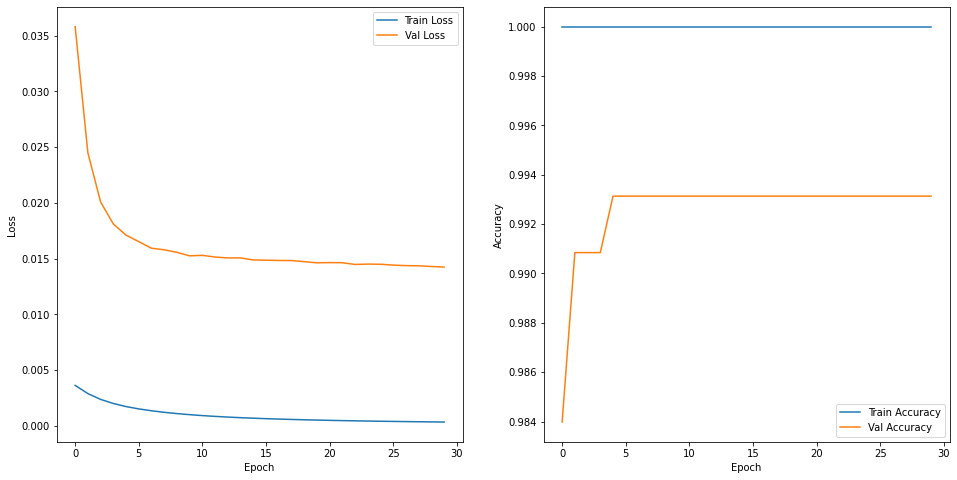

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

plot_history(log) # 그래프가 벌어지면 과적합현상이 생기기 시작한것.

In [ ]:
# !unzip /content/Rock-Paper-Scissor.v4i.multiclass.zip

In [ ]:
import pathlib
final_dir = pathlib.Path('/content/new')

In [ ]:
final_ds = tf.keras.utils.image_dataset_from_directory(
    final_dir,
    image_size = image_size,
    batch_size = batch_size,
    seed = 2022
)

Found 33 files belonging to 1 classes.


In [ ]:
final_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
final_ds = final_ds.map(
    lambda img, label : (data_augment(img), label),
    num_parallel_calls = tf.data.AUTOTUNE
)


In [ ]:
model.evaluate(final_ds)

55/55 [==============================] - 2s 28ms/step - loss: 4.8260e-04 - accuracy: 1.0000


[0.00048259846516884863, 1.0]

In [ ]:
final1_dir = pathlib.Path('/content/new1')

In [ ]:
final1_ds = tf.keras.utils.image_dataset_from_directory(
    final1_dir,
    image_size = image_size,
    batch_size = batch_size,
    seed = 2022
)

Found 53 files belonging to 1 classes.


In [ ]:
final1_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
final1_ds = final_ds.map(
    lambda img, label : (data_augment(img), label),
    num_parallel_calls = tf.data.AUTOTUNE
)


In [ ]:
model.evaluate(final1_ds)

55/55 [==============================] - 2s 27ms/step - loss: 4.8260e-04 - accuracy: 1.0000


[0.00048259846516884863, 1.0]